In [16]:
# # 这是我电脑自己环境的问题，你们不用运行
# import sys
# sys.path
# sys.path.remove('C:\\Users\\Lenovo\\AppData\\Roaming\\Python\\Python38\\site-packages')

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
from math import *
import random
from scipy.optimize import fmin

colors = ["grey", "brown", "orange", "olive", "green", "cyan",
              "blue", "purple", "pink", "red"]

# colors = ['black', 'gray', 'firebrick', 'red', 'chocolate',
#               'orange', 'peru', 'darkgoldenrod', 'olive',
#               'yellow', 'green', 'turquoise', 'deepskyblue',
#               'blue', 'violet', 'purple', 'deeppink']

# Kmeans

## 0. LDA, DSC, dDSC, GONG Function

In [18]:
# 返回质心向量
def getTwoClassMean(c0, c1):
    """
    get the mean vector of two class
    """
    mean0_vectors = np.mean(c0, axis=0)
    mean1_vectors = np.mean(c1, axis=0)
    return mean0_vectors, mean1_vectors
# 返回SW SB
def getClassScatterMatrix(c0, c1):
    """
    input two class data
    return the scatter for each class
    and with-in sc_mat and between sc_mat
    """
    mean0_vectors, mean1_vectors = getTwoClassMean(c0, c1)
    num0 = c0.shape[0]
    num1 = c1.shape[0]
    dim = c0.shape[1]
    class0_sc_mat = np.zeros((dim, dim))
    mv = mean0_vectors.reshape((dim, 1))
    for row in c0:
        row = row.reshape((dim, 1))
        class0_sc_mat += (row-mv).dot((row-mv).T)
    class1_sc_mat = np.zeros((dim, dim))
    mv = mean1_vectors.reshape((dim, 1))
    for row in c1:
        row = row.reshape((dim, 1))
        class1_sc_mat += (row-mv).dot((row-mv).T)
    S_W = class0_sc_mat + class1_sc_mat
    c = np.concatenate((c0, c1))  # Vertical stacking, default axis is 0
    overall_mean = np.mean(c, axis=0)
    overall_mean = overall_mean.reshape((dim, 1))
    mean_vec = mean0_vectors.reshape((dim, 1))
    S_B = np.zeros((dim, dim))
    S_B += num0 * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    mean_vec = mean1_vectors.reshape((dim, 1))
    S_B += num1 * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    return class0_sc_mat, class1_sc_mat, S_W, S_B


# 返回LDA目标函数在该投影下的值
def getLDAValue(S_W, S_B, w):
    result_cost = 1.0 * w.T.dot(S_B).dot(w) / w.T.dot(S_W).dot(w)
    return result_cost


def lda(c0, c1):
    """
    type is ndarray
    shape like (200,2) and 200 is the number of samples and 2 is the number of features
    pass two class data to the function
    return the Eigenvectors using LDA
    the solve method is Eigenvalue Decomposition
    """
    # get the basic information
    dim = c0.shape[1]  # the dim is the number of features, for instance, the dim of iris is 4
    c = np.concatenate((c0, c1))  # Vertical stacking, default axis is 0
    overall_mean = np.mean(c, axis=0)  # the overall_mean of the samples
    # print("overall_mean: ", overall_mean)
    num0 = c0.shape[0]  # the number of class-0
    num1 = c1.shape[0]  # the number of class-1

    # Computing the mean vectors
    mean0_vectors = np.mean(c0, axis=0)
    mean1_vectors = np.mean(c1, axis=0)
    S_W = np.zeros((dim, dim))
    class0_sc_mat = np.zeros((dim, dim))
    mv = mean0_vectors.reshape(dim, 1)
    # print("mv: ", mv)
    for row in c0:
        row = row.reshape(dim, 1)
        # print("row-mv: \n", row-mv)
        class0_sc_mat += (row-mv).dot((row-mv).T)
        # print("class0_sc_mat: ", class0_sc_mat)
    S_W += class0_sc_mat
    # print("within-class Scatter Matrix: \n", S_W)

    # for class1, al S_W1
    class1_sc_mat = np.zeros((dim, dim))
    mv = mean1_vectors.reshape((dim, 1))
    # print("mv: ", mv)
    for row in c1:
        row = row.reshape(dim, 1)
        class1_sc_mat += (row-mv).dot((row-mv).T)
        
    
    S_W += class1_sc_mat
    # print("within-class Scatter Matrix: \n", S_W)

    # Between-class scatter matrix S_B
    S_B = np.zeros((dim, dim))
    # print("overall_mean: ", overall_mean)
    overall_mean = overall_mean.reshape(dim, 1)
    mean_vec = mean0_vectors.reshape(dim, 1)
    S_B += num0*(mean_vec-overall_mean).dot((mean_vec-overall_mean).T)
    mean_vec = mean1_vectors.reshape(dim, 1)
    S_B += num1*(mean_vec-overall_mean).dot((mean_vec-overall_mean).T)
    # print("between-class Scatter Matrix: \n", S_B)

    eig_vals, eig_vecs = np.linalg.eig(np.linalg.pinv(S_W).dot(S_B))
    # for i in range(len(eig_vals)):
    #     eigvec_sc = eig_vecs[:, i].reshape(dim, 1)
    #     print("\nEigenvector {}: \n{}".format(i+1, eigvec_sc.real))
    #     print("Eigenvalue {:}: {:.2e}".format(i+1, eig_vals[i].real))

    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]

    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)


    return [i[1] for i in eig_pairs]


In [19]:
def get_distance_to_point(P1, P2):

    dx = abs(P1[0] - P2[0])
    dy = abs(P1[1] - P2[1])
    return math.sqrt(dx * dx + dy * dy)


# 计算一个点的GONG值，即所定义的set中与自己同类别所占的比例
def cal_one_point_GONG(Points, Label, i):
    omega = 0
    same_indicator = 0
    tot_num = Points.shape[0]
    for j in range(tot_num):
        if j == i:
            continue
        flag = True
        intermediary_point = 0.35 * Points[j] + 0.65 * Points[i]
        int2j_dist = get_distance_to_point(intermediary_point, Points[j])
        for k in range(tot_num):
            if k == i:
                continue
            dist = get_distance_to_point(intermediary_point, Points[k])
            if dist < int2j_dist:
                flag = False
                break
        if flag == False:
            continue
        omega += 1
        if Label[i] == Label[j]:
            same_indicator += 1
    if omega == 0:
        return 0
    return same_indicator/omega


# 计算某个类的GONG值
def get_label_GONG(Points, Label, lab):
    GONG_list = []
    tot_num = Points.shape[0]
    for i in range(tot_num):
        GONG_list.append(cal_one_point_GONG(Points, Label, i))
    GONG_list = np.array(GONG_list)
    return np.mean(GONG_list[Label == lab])

# 返回每个点的GONG值
def getGONGSepList(Points, Label):
    gongSepList = []
    tot_num = Points.shape[0]
    for i in range(tot_num):
        gongSepList.append(cal_one_point_GONG(Points, Label, i))
    return gongSepList


# 计算一个投影的GONG
def get_GONG_value(data, Label, evaluation):
    if evaluation == "Silhouette Coefficient":
        return metrics.silhouette_score(Points, Label)
    answer = 0
    for lab in set(label):
        answer += get_label_GONG(data,label,lab) * len(label[label == lab]) / len(label)
    return answer
    
    
def get_weighted_GONG(data, label, proj_set, proj_set_labels):
    """
    计算整个图的加权GONG值
    输入：原始数据data，label，投影集projection_set
    data和一个投影平面projection_set[i],可以组成投影后的data_
    对于每个类：
    计算这个类在所有投影中的GONG
    取最大值，作为这个类的GONG
    最终对每个类的GONG加权，得到整个图的加权GONG
    """
    proj_num = len(proj_set)
    
    label_count = {}
    GONG = []# GONG[i][j] 代表：在投影i上，第j个类的GONG值
    for i in range(proj_num):
        proj = proj_set[i]
        proj_label = proj_set_labels[i]
        GONG_list = {}

        data_0, data_1, data_, label_ = project_on_merged_vectors(data, label, set(proj_label), proj[0], proj[1])
        
        # 计算该投影下每一个类的GONG
        for lab in set(label_): 
            GONG_list[lab] = get_label_GONG(data_,label_,lab)
            label_count[lab] = len(label[label==lab])
            
        print(GONG_list)
        # 存入GONG
        GONG.append(GONG_list)
        
    label_GONG = {}
    for GONG_list in GONG:
        for key in GONG_list:
            if key not in label_GONG:
                label_GONG[key] = GONG_list[key]
            else:
                label_GONG[key] = max(label_GONG[key], GONG_list[key])
            
    print('-------')
    print(label_GONG)
    print(label_count)
    weighted_GONG = 0 
    
    cnt = 0
    for key in label_GONG:
        weighted_GONG += label_GONG[key] * label_count[key]
        cnt += label_count[key]

    weighted_GONG /= cnt
    return weighted_GONG

## 1. Load and preprocess data

In [20]:
def read_data_from_file(filename):
    """
    :param filename: the data file, the format is class_label, dim0, dim1, ...
    :return: data and label
    """
    newfilename = './Data/' + filename  # because my data is in the Data folder
    data = []
    with open(newfilename, 'r') as f:
        for line in f:
            data.append(list(eval(line)))
    data = np.array(data)
    dim = data.shape[1]
    return data[:, 1:dim], data[:, 0]


# # 重新编排label为0, 1, 2,...
def get_label_right(label):
    class_label = list(set(label))
    label_dict = {}
    re_label = 0
    for it in class_label:
        label_dict[it] = re_label
        re_label += 1
    new_label = []
    for it in label:
        new_label.append(label_dict[it])
    return np.array(new_label)

In [21]:
# Change the following two lines to fit your data
fname = "hiv.csv"  # the class data file
data, label = read_data_from_file(fname)
label = get_label_right(label)
label = np.array(list(map(int, label)))
print(data.shape)
print(label)

(78, 159)
[1 0 0 1 3 3 1 1 0 1 0 3 1 1 3 1 1 3 3 1 1 0 5 1 1 0 3 3 3 3 1 2 4 3 1 0 2
 2 3 0 1 4 0 0 0 1 0 3 1 3 0 3 1 1 2 3 3 2 3 2 1 1 4 3 1 0 3 0 2 2 3 3 3 3
 3 1 2 2]


## 2. Calculate the box

In [22]:
#？
# 确保该向量方向是对的

def get_right_direction(vec, last_axis):
    if np.dot(vec, last_axis) < 0:
        return -vec
    return vec


# 第一步：寻找LDA下的最佳discriminative vector
def get_optimal_vector_from_lda(c0, c1):
    discriminating_vectors = lda(c0, c1)
    opt_vec = np.real(discriminating_vectors[0])  # ndarray
    return opt_vec


#？last_axis
# 寻找每两个类之间的最佳投影向量  (c0,c1):vector
def get_between_class_opt_vec(data, label):
    """
    :param data: the input data
    :param label: The label of the data
    :return: the optimal discriminant vector corresponding to (class a, class b)
    """
    class_list = list(set(label))
    vec_dict = {}
    class_num = len(class_list)
    # dim = data.shape[1]
    # last_axis = np.array([0 for i in range(dim)])
    # last_axis[dim - 1] = last_dim
    # 对于每两个类
    for i in range(class_num):
        for j in range(i+1, class_num):
            # 计算最佳投影向量并加入字典
            opt_vec = get_optimal_vector_from_lda(data[label == class_list[i]],data[label == class_list[j]])
            # opt_vec = get_right_direction(opt_vec, last_axis)
            vec_dict[(class_list[i], class_list[j])] = opt_vec
    vecs = []
    for key in vec_dict:
        vecs.append(vec_dict[key])
    vecs = np.array(vecs)
    return vec_dict, vecs

In [23]:
vec_dict, vecs = get_between_class_opt_vec(data, label)
print(vec_dict)

{(0, 1): array([ 1.65969385e-02, -3.88062268e-02, -1.36713792e-01, -4.77822855e-02,
        3.78331299e-02,  8.29274777e-02,  2.40450901e-01, -1.22413278e-01,
       -8.54149106e-02, -7.25544493e-02, -6.70500759e-02, -1.23660422e-01,
       -1.25387738e-01, -1.87202384e-01, -1.09075658e-01,  2.84014710e-02,
       -3.53470691e-03,  1.11281593e-02,  1.24113897e-03, -2.12425716e-01,
        9.62566092e-04,  7.01512454e-02,  3.03947855e-02,  2.07489728e-02,
        4.99872567e-02,  2.46997776e-02, -1.40069645e-02, -2.12815077e-02,
       -8.42921037e-03, -2.54436066e-02, -1.03173370e-02,  1.17742712e-01,
        7.01538934e-02, -1.06278247e-02, -7.73547614e-03,  1.45341174e-02,
        3.53888316e-03, -1.92662460e-04, -1.35046658e-01,  7.14898228e-05,
        3.51234307e-03,  2.51762837e-01,  1.65468643e-03, -5.84956708e-02,
        2.85876147e-02, -1.82933823e-03, -1.92187554e-03,  1.39500435e-01,
       -1.01839485e-01,  3.77528947e-03, -1.10361584e-01,  6.98040640e-03,
       -8.955477

In [24]:
def get_id_pair(vec_dict):
    i = 0
    id_pair = {}
    for key in vec_dict:
        id_pair[i] = key
        i += 1
    return id_pair

In [25]:
id_pair = get_id_pair(vec_dict)

In [26]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [27]:
def fmin_fun(self, vecs, n_iter=100000, eps=1e-6, lr=1e-2):
    prev_dists = 1e5
    length = len(vecs)
    v1, v2 = self.normalize(np.random.random(length)), self.normalize(np.random.random(length))
    for _ in range(n_iter):
        dv1 = 0
        dv2 = 0
        for v in vecs:
            f1, g1 = fAndG(v, v1, v2, v1)
            f2, g2 = fAndG(v, v1, v2, v2)
            dv1 += g1
            dv2 += g2

        v1 -= lr * dv1 / length
        v2 -= lr * dv2 / length

        plain = np.array([v1, v2])
        get_dist = get_dist_to_plain(plain, vecs)
        if abs(get_dist - prev_dists) < eps:
            break
        prev_dists = get_dist
            
    plain = np.array([v1, v2])
    return plain
    
    
def fAndG(v, v1, v2, v0):  # 对v0求导，v0可以换成v1,v2
    assert isinstance(v, np.ndarray)
    dim = v.shape
    assert len(dim) == 1
    v_rows = dim[0]
    assert isinstance(v1, np.ndarray)
    dim = v1.shape
    assert len(dim) == 1
    v1_rows = dim[0]
    assert isinstance(v2, np.ndarray)
    dim = v2.shape
    assert len(dim) == 1
    v2_rows = dim[0]
    assert v1_rows == v_rows == v2_rows

    t_0 = ((v - ((v1).dot(v) * v1)) - ((v2).dot(v) * v2))
    functionValue = (np.linalg.norm(t_0) ** 2)#目标值
    gradient = -(((2 * (v).dot(v0)) * t_0) + ((2 * (t_0).dot(v0)) * v))

    return functionValue, gradient



#vecs : [vec1, vec2, ... , vecn]
#vec: [x1, x2, x3 ... ]
def combination(vecs):
    planes = []
    for i in range(len(vecs)):
        for j in range(i + 1, len(vecs)):
            plane = [vecs[i], vecs[j]]
            planes.append(plane)
    return planes

        

array([1, 3, 1, 1, 1, 2, 1, 1], dtype=int32)

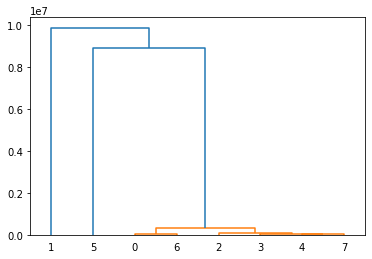

In [37]:
#验证层次聚类

import numpy
import pandas
import scipy.cluster.hierarchy as hcluster
#iris = datasets.load_iris()
#data = iris.data
#target = iris.target
points = [[123, 321, 434, 4325, 345345], [23124, 141241, 434234, 9837489, 34743],
          [128937, 127, 12381, 424, 8945], [322, 4348, 5040, 8189, 2348],
          [51249, 42190, 2713, 2319, 4328], [13957, 1871829, 8712847, 34589, 30945],
          [1234, 45094, 23409, 13495, 348052], [49853, 3847, 4728, 4059, 5389]]
# Compute and plot first dendrogram.
linkage = hcluster.linkage(points, method='centroid')
hcluster.dendrogram(linkage,  leaf_font_size=10.)
p = hcluster.fcluster(linkage,  3, criterion='maxclust')
p

In [36]:
# 测试层次聚类2

import sys
import os
import numpy as np


class Hierarchical:
    def __init__(self, center, left=None, right=None, flag=None, distance=0.0):
        self.center = center
        self.left = left
        self.right = right
        self.flag = flag
        self.distance = distance


def traverse(node):
    if node.left == None and node.right == None:
        return [node.center]
    else:
        return traverse(node.left)+traverse(node.right)


def distance(v1, v2):
    if len(v1) != len(v2):
        print("出现错误了")
        return -1
    distance = 0
    for i in range(len(v1)):
        distance += (v1[i]-v2[i])**2
    distance = np.sqrt(distance)
    return distance


def hcluster(data, n):
    if len(data) <= 0:
        print('invalid data')
    # 初始化每一点为一个簇
    clusters = [Hierarchical(data[i], flag=i) for i in range(len(data))]
    # 距离字典
    distances = {}
    min_id1 = None
    min_id2 = None
    currentCluster = -1

    while len(clusters) > n:
        minDist = 100000000000000

        for i in range(len(clusters)-1):
            for j in range(i+1, len(clusters)):
                # 计算两两簇之间的距离
                if distances.get((clusters[i], clusters[j])) == None:
                    distances[(clusters[i].flag, clusters[j].flag)] = distance(
                        clusters[i].center, clusters[j].center)

                # 如果距离小于目前遇到的最小距离
                # 记录这两个簇ID以及最小距离
                if distances[(clusters[i].flag, clusters[j].flag)] <= minDist:
                    min_id1 = i
                    min_id2 = j
                    minDist = distances[(clusters[i].flag, clusters[j].flag)]

        # 如果存在最小距离
        if min_id1 != None and min_id2 != None and minDist != 1000000000:
            # 则把这两个ID对应的簇合并
            newCenter = [(clusters[min_id1].center[i]+clusters[min_id2].center[i]
                          )/2 for i in range(len(clusters[min_id2].center))]
            newFlag = currentCluster
            currentCluster -= 1
            newCluster = Hierarchical(
                newCenter, clusters[min_id1], clusters[min_id2], newFlag, minDist)
            del clusters[min_id2]
            del clusters[min_id1]
            clusters.append(newCluster)

    finalCluster = [traverse(clusters[i]) for i in range(len(clusters))]
    return finalCluster


if __name__ == '__main__':
    data = [[123, 321, 434, 4325, 345345], [23124, 141241, 434234, 9837489, 34743],
            [128937, 127, 12381, 424, 8945], [322, 4348, 5040, 8189, 2348],
            [51249, 42190, 2713, 2319, 4328], [
                13957, 1871829, 8712847, 34589, 30945],
            [1234, 45094, 23409, 13495, 348052], [49853, 3847, 4728, 4059, 5389]]
    # print(len(data))
    finalCluster = hcluster(data, 3)
    print(finalCluster)
    # print(len(finalCluster[0]))


[[[23124, 141241, 434234, 9837489, 34743]], [[13957, 1871829, 8712847, 34589, 30945]], [[123, 321, 434, 4325, 345345], [1234, 45094, 23409, 13495, 348052], [128937, 127, 12381, 424, 8945], [322, 4348, 5040, 8189, 2348], [51249, 42190, 2713, 2319, 4328], [49853, 3847, 4728, 4059, 5389]]]


TypeError: 'module' object is not callable

In [33]:
class K_Means(object):
    # k是分组数；tolerance‘中心点误差’；max_iter是迭代次数
    def __init__(self, k = 2, tolerance=1e-9, max_iter=300):
        self.k_ = k
        self.tolerance_ = tolerance
        self.max_iter_ = max_iter
        self.labels_ = None
        
    def fmin_fun(self, vecs, n_iter=100000, eps=1e-6, lr=1e-2):
        prev_dists = 1e5
        length = len(vecs[0])
        v1, v2 = self.normalize(np.random.random(
            length)), self.normalize(np.random.random(length))
        for _ in range(n_iter):
            dv1 = 0
            dv2 = 0
            for v in vecs:
                f1, g1 = self.fAndG(v, v1, v2, v1)
                f2, g2 = self.fAndG(v, v1, v2, v2)
                dv1 += g1
                dv2 += g2

            v1 -= lr * dv1 / length
            v2 -= lr * dv2 / length

            plain = np.array([v1, v2])
            get_dist = np.sum([self.get_dist_to_plain(plain, feature) for feature in vecs])
            if abs(get_dist - prev_dists) < eps:
                break
            prev_dists = get_dist

        plain = np.array([v1, v2])
        return plain


    def fAndG(self,v, v1, v2, v0):  # 对v0求导，v0可以换成v1,v2

        assert isinstance(v, np.ndarray)
        dim = v.shape
        assert len(dim) == 1
        v_rows = dim[0]
        assert isinstance(v1, np.ndarray)
        dim = v1.shape
        assert len(dim) == 1
        v1_rows = dim[0]
        assert isinstance(v2, np.ndarray)
        dim = v2.shape
        assert len(dim) == 1
        v2_rows = dim[0]
        assert v1_rows == v_rows == v2_rows

        t_0 = ((v - ((v1).dot(v) * v1)) - ((v2).dot(v) * v2))
        functionValue = (np.linalg.norm(t_0) ** 2)  # 目标值
        gradient = -(((2 * (v).dot(v0)) * t_0) + ((2 * (t_0).dot(v0)) * v))

        return functionValue, gradient



    def normalize(self, v):
        return v / np.linalg.norm(v)
        
    def get_dist_to_plain(self, plain, v):
        length = int(len(plain)/2)
        v1, v2 = np.array(plain[0]), np.array(plain[1])
        new_v = np.dot(np.dot(v1,v),v1) + np.dot(np.dot(v2,v),v2)
        return np.linalg.norm(v-new_v)
    
    
    def get_fitted_plain(self, vecs):
        if len(vecs) == 2:
            axis1, axis2 = vecs[0], vecs[1]
        
            axis1 = self.normalize(axis1)
            a = 1
            axis1_length = 1
            b = -a / np.dot(axis2, axis1)
            axis2 = self.normalize(a*axis1+b*axis2)
            return np.array([axis1, axis2])
    

        length = len(vecs[0])

        
        ans = self.fmin_fun(vecs)

        axis1, axis2 = ans[0], ans[1]
        # print('ans', ans)
        print('axis1', axis1)
        print('axis2', axis2)
        plain = np.array([axis1, axis2])
        
        
        axis1 = self.normalize(axis1)
        a = 1
        axis1_length = 1
        b = -a / np.dot(axis2, axis1)
        axis2 = self.normalize(a*axis1+b*axis2)
        
        plain = np.array([axis1, axis2])
        print('dists-->', np.sum([self.get_dist_to_plain(plain, feature) for feature in vecs]))
        return plain
    
        
    def get_init_plain(self, vecs, k):
        print(vecs)
        np.random.shuffle(vecs)
        plains = {}
        for id1 in range(k):
            for id2 in range(id1+1, k):
                id1, id2 = np.random.randint(0, len(vecs), size=2)
                print(id1, id2)
                axis1, axis2 = self.get_fitted_plain(np.array([vecs[id1], vecs[id2]]))
                plains[id1] = np.array([axis1, axis2])
        # 验证
        # print('!!!',self.get_dist_to_plain(np.array([axis1, axis2]), vecs[id1]))
        return plains
        
    
    

    def fit(self, data):
        
        # 初始化初始平面
        self.centers_ = {}
        self.labels_ = [-1]*len(data)
        # self.centers_ = random.sample(data, self.k_)
        self.centers_ = self.get_init_plain(data,self.k_) # 带改为随机选取
        
                
        # 对每一次迭代
        for _ in range(self.max_iter_):
            # print('-'*80)
            self.clf_ = {}
            for i in range(self.k_):
                self.clf_[i] = []
            # 对每一个数据点
            j = 0
            for feature in data:
                distances = []
                # 计算到每一个平面的距离
                for plain in self.centers_.values():
                    # print(plain)
                    distances.append(self.get_dist_to_plain(plain, feature))
                # 找到距离最近的簇的下标并加入该簇
                
                classification = distances.index(min(distances))
                # print(distances, '--->', j, classification)
                self.labels_[j] = classification
                j = j + 1
                self.clf_[classification].append(feature)

            # print('x'*80)
            # print(self.clf_)
            prev_centers = dict(self.centers_)
            for c in self.clf_:
                axis1, axis2 = self.get_fitted_plain(np.array(self.clf_[c])) # 待考证
                plain = np.array([axis1, axis2])
#                 print('dists-->', np.sum([self.get_dist_to_plain(plain, feature) for feature in self.clf_[c]]))
#                 print('cluster--> ',self.clf_[c])
                self.centers_[c] = np.array([axis1, axis2])
                # print('plaine--> ',self.centers_[c])
                # print('*'*80)
                

            # '中心点'是否在误差范围
            optimized = True
            for center in self.centers_:
                org_centers = prev_centers[center]
                cur_centers = self.centers_[center]
                # print(org_centers, cur_centers)
                if np.sum((cur_centers - org_centers) / org_centers * 100.0) > self.tolerance_:
                    optimized = False
            if optimized:
                break
                
        return self.centers_

    def predict(self, p_data):
        if p_data.ndim == 1:
            distances = [get_dist_to_plain(center, p_data) for center in self.centers_]
            index = distances.index(min(distances))
            return index
        else:
            index = []
            print(self.centers_)
            for feature in p_data:
                distances = [self.get_dist_to_plain(center, feature) for center in self.centers_.values()]
                index.append(distances.index(min(distances)))
            return index

In [29]:
def normalize(v):
    return v / np.linalg.norm(v)

def get_proj_set_and_cluster(vecs, n_cluster=2):
    # kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(vecs)
    km = K_Means(k=n_cluster)
    proj_set = km.fit(vecs)
    print('*'*80,'\n', proj_set)
    km_labels = np.array(km.labels_)
    # print(km_labels)
    # clusters = []
    vecs_label = []
    
    
    # clu is the key of proj_set, referring the ID of cluster
    # km_labels refers to the cluster ID each vector belong to
    for clu in proj_set:
        ids = np.arange(len(vecs))[km_labels == clu]
        vec = vecs[ids]
        print('test-->',np.sum([km.get_dist_to_plain(proj_set[clu], v) for v in vec]))
        labels = [id_pair[i][0] for i in ids]
        labels.extend([id_pair[i][1] for i in ids])
        vecs_label.append(np.array(list(set(labels))))
#         res = []
#         for v in vec:
#             res.append(normalize(v))
#         res = np.array(res)
#         if res.ndim == 1:
#             res = res[np.newaxis, :]
#         clusters.append(res)

    # clusters = np.array(clusters)
    return proj_set, vecs_label

In [30]:
proj_set, vecs_label = get_proj_set_and_cluster(vecs, 3)
print(proj_set)
print(vecs_label)

[[ 1.65969385e-02 -3.88062268e-02 -1.36713792e-01 ... -1.19542464e-02
   9.09825002e-02 -8.79583140e-02]
 [ 9.19813059e-03 -3.77788731e-03  1.57468860e-01 ...  3.15794549e-02
   2.10166501e-02 -5.46879639e-02]
 [ 5.24866215e-02 -2.16483179e-01 -2.79762756e-02 ...  6.82426619e-02
  -2.75694043e-02 -2.86354566e-02]
 ...
 [-5.03845904e-02 -7.59619885e-03  9.84505621e-03 ... -2.00793261e-02
  -1.91325750e-03  2.03291138e-02]
 [ 2.86622920e-02 -9.45129591e-02  4.31184427e-02 ... -3.29089789e-03
   5.44623279e-04  2.31166869e-03]
 [-6.57409297e-07  6.42649350e-01 -5.13381594e-02 ...  2.03439024e-04
   5.20046902e-05 -3.57787264e-04]]
8 13
0 6
8 5
axis1 [ 3.30831077e-03  2.45208838e-02 -2.56868143e-02 -8.16983436e-02
  2.32974735e-01  1.04114330e-02  1.79854845e-01  1.85374257e-01
 -4.50773499e-02 -2.89555940e-02 -1.12153462e-01 -2.33079422e-02
  2.42377730e-02 -9.13333745e-03  6.81446275e-02 -1.22400176e-02
 -9.88126865e-03 -9.60536940e-03  9.48982837e-03 -2.16179484e-02
 -8.45877637e-02 -7.

IndexError: index 0 is out of bounds for axis 0 with size 0

[[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]
None


In [ ]:
def project_on_merged_vectors(data, label, plot_class_set, axis1, axis2, ax=None):
    '''
        axis?: 一个向量集所对应的box区域的交集部分的中心向量
        set? : axis?所对应的向量集所能区分的labels
        
    '''
    data_0 = []
    data_1 = []
    label_ = []
    for it in set(plot_class_set):
        x = np.dot(data[label == it], axis1)
        if it in plot_class_set:
            data_0.extend(list(x))
        
        if len(axis2):
            y = np.dot(data[label == it], axis2)
            if it in plot_class_set:
                data_1.extend(list(y))
            
        if it in plot_class_set:
            label_.extend([it]*len(x))
        
        if ax:
            if it in plot_class_set:
                ax.scatter(x, y, color=get_corresponding_color(it), label=str(it), alpha=1, s=10)
            else:
                ax.scatter(x, y, color=get_corresponding_color(it), label=str(it), alpha=0.1, s=10)
                
                
    if ax:
        ax.legend(loc='center left', bbox_to_anchor=(0.2, 1.12),ncol=3)
    
    if len(axis2) == 0:
        data_1 = [0 for _ in range(len(data_0))]
        
    data_ = np.vstack([data_0,data_1]).T
    label_ = np.array(label_)
    return data_0, data_1, data_, label_   
    


In [ ]:
def get_corresponding_color(id):
    return colors[id]

def draw_projection(proj_set, data, label, vecs_label):
    plot_tot = int(len(proj_set))

    # 投影后的点的矩阵的shape
    row_num = int(np.ceil(plot_tot / 2.0))
    col_num = 2     # 列数=总图数/行数

    fig, ax = plt.subplots(nrows=row_num, ncols=col_num, squeeze=False, figsize=(10, 10))

    pos = 0 

    # 对每一个图
    for i in range(row_num):
        for j in range(col_num):
            proj = proj_set[pos]
            sep_labels = [i for i in vecs_label[pos]]
            print(sep_labels)
            project_on_merged_vectors(data, label, sep_labels, proj[0], proj[1], ax[i][j])
            pos += 1
            if pos == plot_tot:
                break
        if pos == plot_tot:
                break

    plt.tight_layout()
        

[0, 1, 2, 3, 4, 5]
[0, 1, 2, 5]
[0, 1, 2, 3, 4, 5]


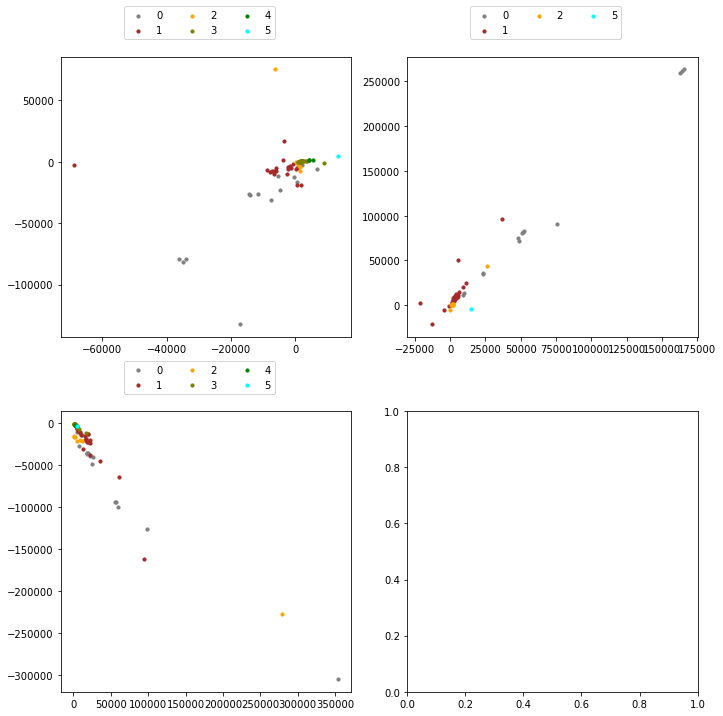

In [ ]:
draw_projection(proj_set, data, label, vecs_label)

In [ ]:
get_weighted_GONG(data, label, proj_set, vecs_label)

{0: 0.6722222222222222, 1: 0.7708333333333334, 2: 0.5333333333333333, 3: 0.8666666666666666, 4: 1.0, 5: 0.0}
{0: 0.8, 1: 0.6944444444444443, 2: 0.7666666666666666, 5: 0.0}
{0: 0.6, 1: 0.6527777777777778, 2: 0.55, 3: 0.7166666666666666, 4: 0.0, 5: 0.0}
-------
{0: 0.8, 1: 0.7708333333333334, 2: 0.7666666666666666, 3: 0.8666666666666666, 4: 1.0, 5: 0.0}
{0: 15, 1: 24, 2: 10, 3: 25, 4: 3, 5: 1}


0.8055555555555555

## Test

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [ ]:
def test_lda(fname, data, label):
    clf = LDA(n_components=2)
    new_data_LDA = clf.fit_transform(data, label)
    plt.scatter(new_data_LDA[:, 0], new_data_LDA[:, 1], c=label,
            cmap=matplotlib.colors.ListedColormap(colors))

    GONG = get_GONG_value(new_data_LDA, label, 'test')
    plt.title('LDA: ' + str(round(GONG, 4)))
    
#     plt.savefig('./result/' + fname + '/' + fname.split('.')[0] + '_LDA.png')
    plt.show()
    
    return GONG

In [ ]:
def test_pca(fname, data, label):
    pca = PCA(n_components=2)
    new_data_PCA = pca.fit_transform(data)

    plt.scatter(new_data_PCA[:, 0], new_data_PCA[:, 1], c=label,
            cmap=matplotlib.colors.ListedColormap(colors))

    GONG = get_GONG_value(new_data_PCA, label, 'test')
    plt.title('PCA: ' + str(round(GONG, 4)))
    
#     plt.savefig('./result/' + fname + '/' + fname.split('.')[0] + '_PCA.png')

    plt.show()
    return GONG

In [ ]:
def test_tsne(fname, data, label):
    sc = StandardScaler()
    data_std = sc.fit_transform(data)

    tsne = TSNE(n_components=2, learning_rate=100)
    new_data_tsne = tsne.fit_transform(data)

    plt.scatter(new_data_tsne[:, 0], new_data_tsne[:, 1], c=label,
            cmap=matplotlib.colors.ListedColormap(colors))

    GONG = get_GONG_value(new_data_tsne, label, 'test')
    plt.title('t-SNE: ' + str(round(GONG, 4)))
    
#     plt.savefig('./result/' + fname + '/' + fname.split('.')[0] + '_TSNE.png')

    plt.show()
    return GONG

In [ ]:
def test_kda(fname, data, label):
    kda = KernelDiscriminantAnalysis()
    a = kda.fit(data, label)
    b = kda.transform(data)
    new_data_KDA = kda.fit_transform(data,label)
    plt.scatter(new_data_KDA[:,0],new_data_KDA[:,1],c=label,cmap = matplotlib.colors.ListedColormap(colors))
    GONG = get_GONG_value(new_data_KDA, label, 'test')
    plt.title('KDA: ' + str(round(GONG, 4)))
    plt.show()
    
#     plt.savefig('./result/' + fname + '/' + fname.split('.')[0] + '_KDA.png')
    return GONG

In [ ]:
"""
Scikit-learn-compatible Kernel Discriminant Analysis.

Used in
David Diaz-Vico, Jose R. Dorronsoro
"Deep vs Kernel Fisher Discriminant Analysis"

Based on algorithm 5 in
Zhihua Zhang, Guang Dai, Congfu Xu, Michael I. Jordan
"Regularized Discriminant Analysis, Ridge Regression and Beyond"
http://www.jmlr.org/papers/v11/zhang10b.html

,author: David Diaz Vico
,license: MIT
"""

import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.metrics.pairwise import (chi2_kernel, laplacian_kernel,
                                      linear_kernel, polynomial_kernel,
                                      rbf_kernel, sigmoid_kernel)
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y
from sklearn.datasets import make_classification
from scipy.sparse import csc_matrix, csr_matrix

class KernelDiscriminantAnalysis(BaseEstimator, ClassifierMixin,
                                 TransformerMixin):
    """Kernel Discriminant Analysis.

    Parameters
    ----------
    lmb: float (>= 0.0), default=0.001
         Regularization parameter
    kernel: {"chi2", "laplacian", "linear", "polynomial", "rbf", "sigmoid"},
            default='rbf'
            Kernel.
    degree: integer, default=3
    gamma: float, default=None
    coef0: integer, default=1

    """

    def __init__(self, lmb=0.001, kernel='rbf', degree=3, gamma=None, coef0=1):
        self.lmb = lmb
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0

    def _kernel(self, X, Y=None):
        """Kernel"""
        kernel = None
        if self.kernel == 'chi2':
            kernel = chi2_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'laplacian':
            kernel = laplacian_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'linear':
            kernel = linear_kernel(X, Y)
        elif self.kernel == 'polynomial':
            kernel = polynomial_kernel(X, Y, degree=self.degree,
                                       gamma=self.gamma, coef0=self.coef0)
        elif self.kernel == 'rbf':
            kernel = rbf_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'sigmoid':
            kernel = sigmoid_kernel(X, Y, gamma=self.gamma, coef0=self.coef0)
        return kernel

    def fit(self, X, y):
        """Fit KFDA model.

        Parameters
        ----------
        X: numpy array of shape [n_samples, n_features]
           Training set.
        y: numpy array of shape [n_samples]
           label values. Only works for 2 classes.

        Returns
        -------
        self

        """
        n = len(X)
        self._X = X
        self._H = np.identity(n) - np.matmul(1. / n * np.ones(n), np.ones(n).T) #np.ones(n) , np.ones(n).T
        self._E = OneHotEncoder().fit_transform(y.reshape(n, 1))
        _, counts = np.unique(y, return_counts=True)
        K = self._kernel(X)
        C = np.matmul(np.matmul(self._H, K), self._H)
        self._Delta = np.linalg.inv(C + self.lmb * np.identity(n))
        A = np.matmul(csc_matrix.toarray(self._E.T), C)
        B = np.matmul(self._Delta , csr_matrix.toarray(self._E))
        self._Pi_12 = np.diag(np.sqrt(1.0 / counts))
        P = np.matmul(self._Pi_12 , A)
        Q = np.matmul(B , self._Pi_12)
        R = np.matmul(P, Q)
        V, self._Gamma, self._U = np.linalg.svd(R, full_matrices=False)
        return self

    def transform(self, X):
        """Transform data with the trained KFDA model.

        Parameters
        ----------
        X: numpy array of shape [n_samples, n_features]
           The input data.

        Returns
        -------
        y_pred: array-like, shape (n_samples, labels_shape)
                Transformations for X.

        """
        _K = self._kernel(X, self._X)
        K = _K - np.mean(_K, axis=0)
        C = np.matmul(self._H, K.T)
        x = np.matmul(np.matmul(self._U, self._Pi_12), csc_matrix.toarray(self._E.T))
        T = np.matmul(x,self._Delta)
        Z = np.matmul(T, C)
        return Z.T

In [ ]:
def run_all(fname, n_cluster):
    # get the data
    data, label = read_data_from_file(fname)
    label = get_label_right(label)
    label = np.array(list(map(int, label)))
    print(data.shape)
    print(label)
    print('+'*80)
    # get the cluster
    vec_dict, vecs = get_between_class_opt_vec(data, label)
    id_pair = get_id_pair(vec_dict)
    clusters, vecs_label = get_cluster(vecs, n_cluster)
    print(clusters)
    print(vecs_label)
    print('-'*100)
    # get the projection
    proj_set = get_proj_set(clusters)
    print(proj_set)
    draw_projection(proj_set, data, label, vecs_label)
    score = get_weighted_GONG(data, label, proj_set, vecs_label)
    print(score)
    return score

## Total

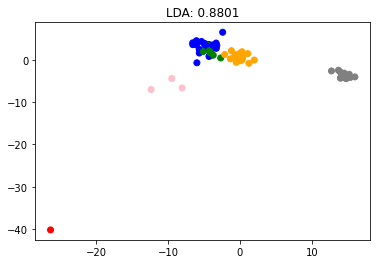

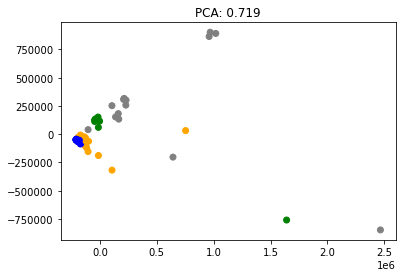

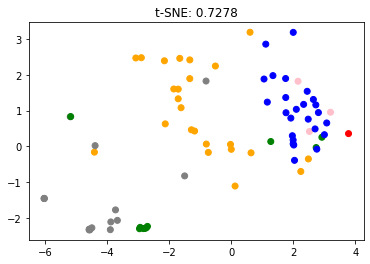

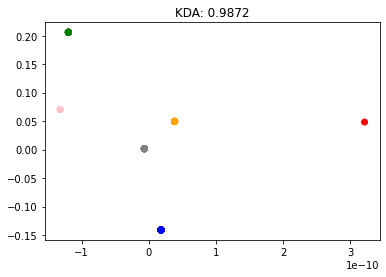

0.9871794871794871

In [ ]:
fname = 'hiv.csv'
data, label = read_data_from_file(fname)
# run_all(fname, 4)
test_lda(fname, data, label)
test_pca(fname, data, label)
test_tsne(fname, data, label)
test_kda(fname, data, label)

In [ ]:
run_all(fname, 4)

(151, 10)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4]
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


NameError: name 'get_cluster' is not defined

In [ ]:
import os

In [ ]:
def run_on_all_file():
    path = r'.\Data'
    dirs = os.listdir(path)
#     print(dirs)
    if not os.path.exists('./result'):
        os.mkdir("result")
    for fname in dirs:
        print(fname)
#         fname = "world_9d.csv"
        if not os.path.exists(r'.\result\\'+fname):
            os.mkdir(r'.\result\\'+fname)
        data, label = read_data_from_file(fname)
        proj_set_GONG = run_all(fname=fname, threshold=0.92)
        lda_GONG = test_lda(fname, data, label)
        pca_GONG = test_pca(fname, data, label)
        tsne_GONG = test_tsne(fname, data, label)
        kda_GONG = test_kda(fname, data, label)
        GONG_list = np.array([proj_set_GONG,lda_GONG,pca_GONG,tsne_GONG,kda_GONG])
        print(fname)
        

In [ ]:
run_on_all_file()

In [ ]:
def test_threshold(fname, measure_option = "dDSC"):
    thresholds = list(np.linspace(0.9, 0.8, 10))
    GONG_list = []
    for threshold in thresholds:
        stime = time.time()
        weighted_GONG = run_all(fname=fname, threshold=threshold)
#         GONG_list.append(weighted_GONG)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    plt.plot(thresholds, GONG_list)
    
    return GONG_list

In [ ]:
test_threshold(fname='world_9d.csv')

In [ ]:
#2个类的文件都要踢出来
path = r'.\Data'
dirs = os.listdir(path)
for fname in dirs:
    data, label = read_data_from_file(fname)
    # if(len(set(label)) <= 3 or len(set(label)) >= 10):
    print(fname,"...",len(set(fname)))

cmc.csv ... 5
hiv.csv ... 6
iris.csv ... 6
lenses.csv ... 7
olive.csv ... 8
satimage.csv ... 10
scene.csv ... 6
seeds.csv ... 6
tse300.csv ... 8
wine.csv ... 8
zoo.csv ... 6
